# **Project : Amazon Product Reviews :: Sentiment Analysis**

### Authors:

*   Chandramouli Sanchi(schandramoul@iisc.ac.in)
*   Josyula Sai Tejaswi(tejaswisai@iisc.ac.in)
*   Mupparthi Vikram(vikramm@iisc.ac.in)



## Resources - https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

### Spark setup

In [3]:
spark.stop()

In [1]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local[2]")\
         .appName("Colab")\
         .config('spark.ui.port', '4050').config("spark.executor.memory", "7g").getOrCreate()
default_parallelism = spark.sparkContext.defaultParallelism
print(f"Default Parallelism: {default_parallelism}")
spark

Default Parallelism: 2


### All the imports for this are mentioned here

In [31]:
from pyspark.sql import Row
from pyspark.sql.functions import expr, lower, regexp_replace, split, udf, regexp_extract, col,size,collect_list,count,explode,when,rand
from pyspark.sql.types import ArrayType, StringType, DoubleType
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Tokenizer, StopWordsRemover,StringIndexer
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_df = spark.read.text("D:\\DE\\archive\\train.ft.txt.bz2") #Please replace the correct path here.
test_df = spark.read.text("D:\\DE\\archive\\test.ft.txt.bz2") #Please replace the correct path here.

### Exploratory Data Analysis

In [7]:
train_df.show(2, truncate=False)
test_df.show(1, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [8]:
# Count the number of rows in the Train DataFrame
num_rows = train_df.count()

# Count the number of columns in the DataFrame
num_columns = len(train_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 3600000
Number of columns: 1


In [9]:
# Count the number of rows in the Test DataFrame
num_rows = test_df.count()

# Count the number of columns in the DataFrame
num_columns = len(test_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 400000
Number of columns: 1


In [62]:
# data has a single column named "value", rename to "text"
train_df = train_df.withColumnRenamed("value", "text")
test_df = test_df.withColumnRenamed("value", "text")

# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
train_df = tokenizer.transform(train_df)
test_df = tokenizer.transform(test_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
train_df = remover.transform(train_df)
test_df = remover.transform(test_df)

+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|           3600000|
|   mean| 442.6463147222222|
| stddev|237.55257109885002|
|    min|                83|
|    max|              1026|
+-------+------------------+



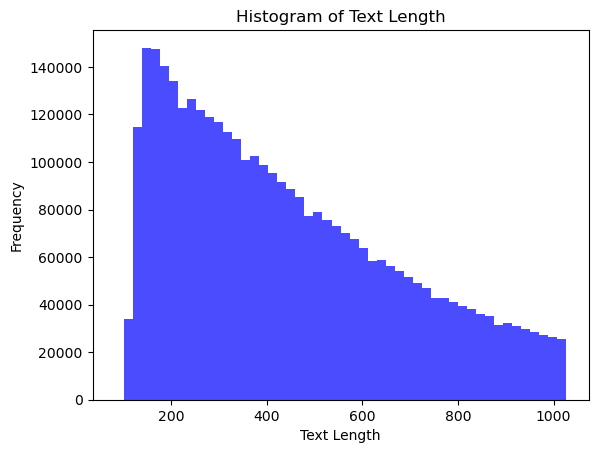

+--------------------+--------------------+
|                text|      filtered_words|
+--------------------+--------------------+
|__label__2 Stunin...|[__label__2, stun...|
|__label__2 The be...|[__label__2, best...|
|__label__2 Amazin...|[__label__2, amaz...|
|__label__2 Excell...|[__label__2, exce...|
|__label__2 Rememb...|[__label__2, reme...|
|__label__2 an abs...|[__label__2, abso...|
|__label__1 Buyer ...|[__label__1, buye...|
|__label__2 Glorio...|[__label__2, glor...|
|__label__2 A FIVE...|[__label__2, five...|
|__label__2 Whispe...|[__label__2, whis...|
+--------------------+--------------------+
only showing top 10 rows



In [63]:
# Add a column for the length of the text
train_df = train_df.withColumn("text_length", length(train_df["text"]))
test_df = test_df.withColumn("text_length", length(test_df["text"]))

# Show basic statistics about text length
train_df.select("text_length").describe().show()

# Plot a histogram of text length
text_lengths = train_df.select("text_length").rdd.flatMap(lambda x: x).collect()
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Show the first few rows of the preprocessed DataFrame
train_df.select("text", "filtered_words").show(10)

In [64]:
# Assuming the labels are in the format __label__1 and __label__2
train_df = train_df.withColumn("label", train_df["text"].substr(10, 1).cast("int"))
test_df = test_df.withColumn("label", test_df["text"].substr(10, 1).cast("int"))

# Count the occurrences of each label
label_counts = train_df.groupBy("label").agg(count("*").alias("count"))

# Show the counts
label_counts.show()

# Alternatively, we can collect the counts as a dictionary for easier access
label_counts_dict = label_counts.rdd.collectAsMap()
print("Number of positive labels (__label__2):", label_counts_dict.get(2, 0))
print("Number of negative labels (__label__1):", label_counts_dict.get(1, 0))

+-----+-------+
|label|  count|
+-----+-------+
|    1|1800000|
|    2|1800000|
+-----+-------+

Number of positive labels (__label__2): 1800000
Number of negative labels (__label__1): 1800000


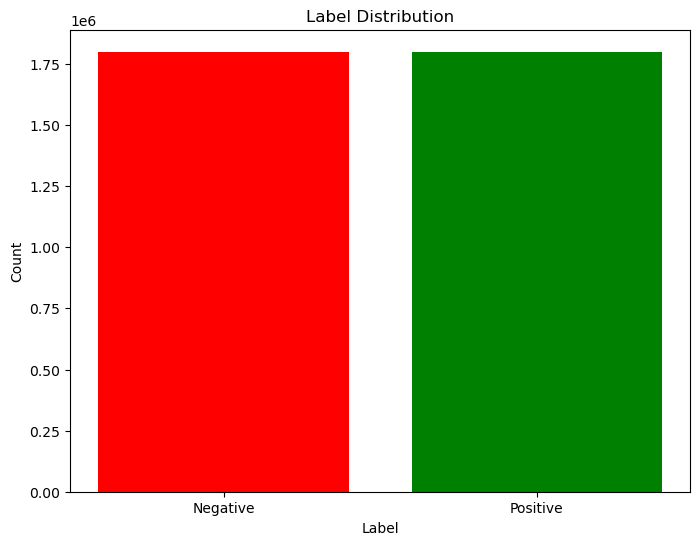

In [65]:
# Count the occurrences of each label
label_counts = train_df.groupBy("label").agg(count("*").alias("count"))

# Convert to Pandas DataFrame for visualization
label_counts_pd = label_counts.toPandas()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(label_counts_pd["label"], label_counts_pd["count"], color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks([1, 2], ['Negative', 'Positive'])
plt.show()

## Reduce the samples to avoid out of memory issues

In [3]:
train_df = spark.read.text("D:\\DE\\archive\\train.ft.txt.bz2") #Please replace the correct path here.
test_df = spark.read.text("D:\\DE\\archive\\test.ft.txt.bz2") 

In [4]:
# Set the seed for reproducibility
seed = 42

# Randomly sample 50% rows from the train DataFrame
train_df = train_df.sample(False, 0.5, seed)  # Change the fraction to get the desired sample size

# Randomly sample 95% rows from the test DataFrame
test_df = test_df.sample(False, 0.95, seed)  # Change the fraction to get the desired sample size

In [32]:
# Check the updated sizes
num_rows_train = train_df.count()
num_rows_test = test_df.count()

print("Updated train data frame size:")
print("Number of rows:", num_rows_train)
print("Number of columns:", num_columns)

print("\nUpdated test data frame size:")
print("Number of rows:", num_rows_test)
print("Number of columns:", num_columns)

Updated train data frame size:
Number of rows: 1800981
Number of columns: 1

Updated test data frame size:
Number of rows: 379950
Number of columns: 1


In [5]:
train_df = train_df.withColumnRenamed("value", "raw_text")
test_df = test_df.withColumnRenamed("value", "raw_text")

In [6]:
# For the training data
# Extract the sentiment label and convert to an integer
train_df = train_df.withColumn("label", regexp_extract("raw_text", r"__label__(\d)", 1).cast("int"))

# Extract the review text (excluding the label)
train_df = train_df.withColumn("text", expr("substring(raw_text, 12)"))

# For the testing data
# Extract the sentiment label and convert to an integer
test_df = test_df.withColumn("label", regexp_extract("raw_text", r"__label__(\d)", 1).cast("int"))

# Extract the review text (excluding the label)
test_df = test_df.withColumn("text", expr("substring(raw_text, 12)"))

In [7]:
# Drop the "raw_text" column from train_df
train_df = train_df.drop("raw_text")

# Drop the "raw_text" column from test_df
test_df = test_df.drop("raw_text")

#convert label 1 to 0 (Negative)
train_df = train_df.withColumn(
    'sentiment',
    when(train_df['label'] == 1, 0).when(train_df['label'] == 2, 1).otherwise(train_df['label'])
)
train_df = train_df.drop('label')

#convert label 1 to 0 (Negative)
test_df = test_df.withColumn(
    'sentiment',
    when(test_df['label'] == 1, 0).when(test_df['label'] == 2, 1).otherwise(test_df['label'])
)
test_df = test_df.drop('label')
# Show the modified DataFrame
train_df.show(10)

test_df.show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|Excellent Soundtr...|        1|
|Glorious story: I...|        1|
|The Worst!: A com...|        0|
|Great Read: I tho...|        1|
|A romantic zen ba...|        1|
|Jobst UltraSheer ...|        1|
|mens ultrasheer: ...|        0|
|Problem with char...|        0|
|Works, but not as...|        0|
|Disappointed: I r...|        0|
+--------------------+---------+
only showing top 10 rows

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|Great CD: My love...|        1|
|One of the best g...|        1|
|Batteries died wi...|        0|
|works fine, but M...|        1|
|Great for the non...|        1|
+--------------------+---------+
only showing top 5 rows



In [47]:
# Count the number of entries for each unique label in the training data
train_label_counts = train_df.groupBy("sentiment").count().orderBy("sentiment")
print("Number of entries for each unique label in training data:")
train_label_counts.show()

# Count the number of entries for each unique label in the test data
test_label_counts = test_df.groupBy("sentiment").count().orderBy("sentiment")
print("Number of entries for each unique label in test data:")
test_label_counts.show()

Number of entries for each unique label in training data:
+---------+------+
|sentiment| count|
+---------+------+
|        0|900892|
|        1|900089|
+---------+------+

Number of entries for each unique label in test data:
+---------+------+
|sentiment| count|
+---------+------+
|        0|189865|
|        1|190085|
+---------+------+



### TF-IDF + Logistic regression

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [16]:
train_df.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|Excellent Soundtr...|        1|
|Glorious story: I...|        1|
|The Worst!: A com...|        0|
|Great Read: I tho...|        1|
|A romantic zen ba...|        1|
|Jobst UltraSheer ...|        1|
|mens ultrasheer: ...|        0|
|Problem with char...|        0|
|Works, but not as...|        0|
|Disappointed: I r...|        0|
|happy with it...b...|        1|
|Rochelle explains...|        1|
|More great playin...|        1|
|Doesn't work on a...|        0|
|Mind numbing: Thi...|        0|
|Cannot recommend:...|        0|
|TERRIBLE!! DO NOT...|        0|
|Kitchen TV: I bou...|        1|
|Great travel guid...|        1|
|Not the best: I b...|        0|
+--------------------+---------+
only showing top 20 rows



In [22]:
label_indexer = StringIndexer(inputCol="sentiment", outputCol="indexedLabel")
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=250) ##this was decided because of mean length being 442. and Stddev is 237
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="indexedLabel", maxIter=22, regParam=0.01,fitIntercept=True, tol=2e-5)

# Create a pipeline
pipeline = Pipeline(stages=[label_indexer, tokenizer, hashingTF, idf, lr])

# Fit the pipeline to the training data
model = pipeline.fit(train_df)

### Evaluation for Model 1 (Using Logistic Regression)

In [29]:
model.save('lrTfIdf42')

In [ ]:
model = PipelineModel.load('lrTfIdf42')

In [12]:
predictions = model.transform(test_df)

In [24]:
predictions.show()

+--------------------+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|indexedLabel|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Great CD: My love...|        1|         1.0|[great, cd:, my, ...|(250,[0,1,6,10,13...|(250,[0,1,6,10,13...|[-1.2978239900569...|[0.21453146364541...|       1.0|
|One of the best g...|        1|         1.0|[one, of, the, be...|(250,[0,4,6,7,10,...|(250,[0,4,6,7,10,...|[-1.1203005115834...|[0.24595554599268...|       1.0|
|Batteries died wi...|        0|         0.0|[batteries, died,...|(250,[6,10,17,23,...|(250,[6,10,17,23,...|[0.54954507004907...|[0.63403003734574...|       0.0|
|works fine, but M...|      

In [13]:
predictions_label_counts = predictions.groupBy("prediction").count().orderBy("prediction")
print("Number of entries for each unique label in test data:")
predictions_label_counts.show()

Number of entries for each unique label in test data:
+----------+------+
|prediction| count|
+----------+------+
|       0.0|185204|
|       1.0|194725|
+----------+------+



In [15]:
predictions_label_counts = predictions.groupBy("sentiment").count().orderBy("sentiment")
print("Number of entries for each unique label in test data:")
predictions_label_counts.show()

Number of entries for each unique label in test data:
+---------+------+
|sentiment| count|
+---------+------+
|        0|190031|
|        1|189898|
+---------+------+



In [14]:
predictions.select('text','prediction').show(3, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                                                     

In [16]:
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy,weightedPrecision,f1")

# Compute multiple metrics
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
weighted_precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
weighted_f1 = evaluator.setMetricName("f1").evaluate(predictions)

# Print the metrics
print("Evaluation Metrics With Logistic Regression")
print("Accuracy:", accuracy)
print("Weighted Precision:", weighted_precision)
print("Weighted F1 Score:", weighted_f1)

Evaluation Metrics With Logistic Regression
Accuracy: 0.7278886318233143
Weighted Precision: 0.7280382868277216
Weighted F1 Score: 0.7278459120953271


In [21]:
predictions.show()

+--------------------+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|indexedLabel|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Great CD: My love...|        1|         1.0|[great, cd:, my, ...|(250,[0,1,6,10,13...|(250,[0,1,6,10,13...|[-1.2978239900569...|[0.21453146364541...|       1.0|
|One of the best g...|        1|         1.0|[one, of, the, be...|(250,[0,4,6,7,10,...|(250,[0,4,6,7,10,...|[-1.1203005115834...|[0.24595554599268...|       1.0|
|Batteries died wi...|        0|         0.0|[batteries, died,...|(250,[6,10,17,23,...|(250,[6,10,17,23,...|[0.54954507004907...|[0.63403003734574...|       0.0|
|works fine, but M...|      

C:\Users\Tejaswi\Downloads\spark-3.5.0-bin-hadoop3\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


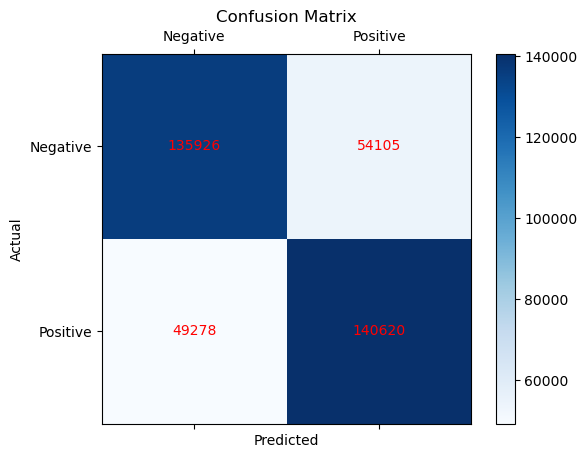

True Positives: 140620.0
False Positives: 54105.0
True Negatives: 135926.0
False Negatives: 49278.0


In [23]:
predictionAndLabels = predictions.select("prediction", "sentiment").rdd.map(lambda row: (float(row.prediction), float(row.sentiment)))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Get confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Extract TP, FP, TN, FN
tp = confusion_matrix[1, 1]  # True Positives
fp = confusion_matrix[0, 1]  # False Positives
tn = confusion_matrix[0, 0]  # True Negatives
fn = confusion_matrix[1, 0]  # False Negatives

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.colorbar(cax)

# Display values inside the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(int(confusion_matrix[i, j])), ha='center', va='center', color='red')

plt.show()

# Print TP, FP, TN, FN
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")

## Decision tree based classification using CV

In [70]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

label_indexer1 = StringIndexer(inputCol="sentiment", outputCol="indexedLabel")
tokenizer1 = Tokenizer(inputCol="text", outputCol="words")
hashingTF1 = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=400) ##this was decided because of mean length being 442. and Stddev is 237
idf1 = IDF(inputCol="rawFeatures", outputCol="features")
dt  = DecisionTreeClassifier(
    labelCol="sentiment",
    featuresCol="features",
    impurity="gini",
    seed=42
)
pipeline1 = Pipeline(stages=[label_indexer1, tokenizer1, hashingTF1, idf1, dt])
# Define the parameter grid for grid search
param_grid1 = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .addGrid(dt.minInstancesPerNode, [1, 5]) \
    .build()

# Create a CrossValidator with a MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")

cross_validator1 = CrossValidator(estimator=pipeline1,
                                 estimatorParamMaps=param_grid1,
                                 evaluator=evaluator1,
                                 numFolds=3) 
cv_model = cross_validator1.fit(train_df)

In [77]:
predictions = cv_model.transform(test_df)
evaluator11 = MulticlassClassificationEvaluator(labelCol="sentiment",predictionCol="prediction",metricName="accuracy,weightedPrecision,f1")

# Compute multiple metrics
accuracy = evaluator11.setMetricName("accuracy").evaluate(predictions2)
weighted_precision = evaluator11.setMetricName("weightedPrecision").evaluate(predictions2)
weighted_f1 = evaluator11.setMetricName("f1").evaluate(predictions2)
# Evaluate the model

print("Accuracy:", accuracy)
print("Weighted Precision:", weighted_precision)
print("Weighted F1 Score:", weighted_f1)


Accuracy: 0.6674431275317231
Weighted Precision: 0.6676115509177853
Weighted F1 Score: 0.6673558480139252


In [79]:
# Get the best set of hyperparameters
best_model = cv_model.bestModel
best_dt_model = best_model.stages[4]  # Assuming the DecisionTreeClassifier is the first stage in the pipeline

print("Best Hyperparameters:")
print(f"Max Depth: {best_dt_model.getMaxDepth()}")
print(f"Max Bins: {best_dt_model.getMaxBins()}")
print(f"Min Instances Per Node: {best_dt_model.getMinInstancesPerNode()}")


Best Hyperparameters:
Max Depth: 10
Max Bins: 32
Min Instances Per Node: 1


In [82]:
best_model.save('DTmodel1')

In [83]:
predictionAndLabels = predictions.select("prediction", "sentiment").rdd.map(lambda row: (float(row.prediction), float(row.sentiment)))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Get confusion matrix
confusion_matrix2 = metrics2.confusionMatrix().toArray()

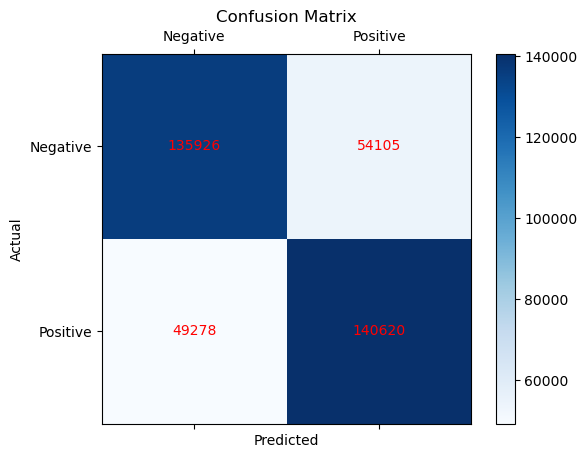

True Positives: 140620.0
False Positives: 54105.0
True Negatives: 135926.0
False Negatives: 49278.0


In [84]:
# Extract TP, FP, TN, FN
tp = confusion_matrix[1, 1]  # True Positives
fp = confusion_matrix[0, 1]  # False Positives
tn = confusion_matrix[0, 0]  # True Negatives
fn = confusion_matrix[1, 0]  # False Negatives

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.colorbar(cax)

# Display values inside the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(int(confusion_matrix[i, j])), ha='center', va='center', color='red')

plt.show()

# Print TP, FP, TN, FN
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")

## Gradient boosted tree classification with Cross validation and Hyper parameter tuning

In [26]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
gbt = GBTClassifier(featuresCol="features", labelCol="indexedLabel",seed=42)

In [37]:
label_indexer = StringIndexer(inputCol="sentiment", outputCol="indexedLabel")
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=150) ##this was decided because of mean length being 442. and Stddev is 237
idf = IDF(inputCol="rawFeatures", outputCol="features")
pipeline2 = Pipeline(stages=[label_indexer, tokenizer, hashingTF, idf, gbt])

In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Create a parameter grid
param_grid = (ParamGridBuilder()
              .addGrid(gbt.maxIter, [10]) ##Give more values here (10,12,15)
              .addGrid(gbt.maxDepth, [7,8]) ##Give more valaues like 6,7,8,9,10 
              .build()) ###Commenting these out to run it easily and quickly.


# Create a classification evaluator and cross validation
crossval = CrossValidator(estimator=pipeline2,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexed_label", metricName="f1"),
                          numFolds=3)
#each fold takes about 15 mins.. so 90 mins. 
#number of tokens we have for this model is 150
# Fit the model
cv_model = cross_validator.fit(train_df)

# Get the best model from cross-validation
best_model = cv_model.bestModel

In [41]:
best_model.save('gbttfidf2')

## Evaluation for this model

In [51]:
predictions2=best_model.transform(test_df)

In [73]:
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy,weightedPrecision,f1")

# Compute multiple metrics
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions2)
weighted_precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions2)
weighted_f1 = evaluator.setMetricName("f1").evaluate(predictions2)

# Print the metrics
print("Evaluation Metrics With GBT Classifier")
print("Accuracy:", accuracy)
print("Weighted Precision:", weighted_precision)
print("Weighted F1 Score:", weighted_f1)

Evaluation Metrics With GBT Classifier
Accuracy: 0.6674431275317231
Weighted Precision: 0.6676115509177853
Weighted F1 Score: 0.6673558480139252


In [55]:
predictions2.select('text','sentiment','prediction').show(6,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------+
|text                                                                                                                                                           

In [85]:
predictionAndLabels2 = predictions2.select("prediction", "sentiment").rdd.map(lambda row: (float(row.prediction), float(row.sentiment)))

# Instantiate MulticlassMetrics
metrics2 = MulticlassMetrics(predictionAndLabels2)

# Get confusion matrix
confusion_matrix2 = metrics2.confusionMatrix().toArray()

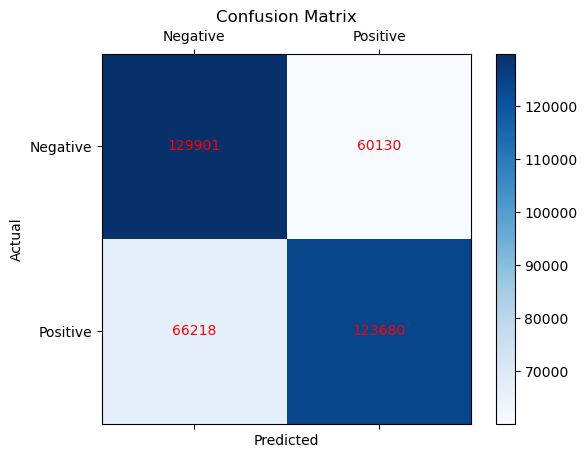

True Positives: 123680.0
False Positives: 60130.0
True Negatives: 129901.0
False Negatives: 66218.0


In [86]:
# Extract TP, FP, TN, FN
tp2 = confusion_matrix2[1, 1]  # True Positives
fp2 = confusion_matrix2[0, 1]  # False Positives
tn2 = confusion_matrix2[0, 0]  # True Negatives
fn2 = confusion_matrix2[1, 0]  # False Negatives

# Plot confusion matrix
fig2, ax2 = plt.subplots()
cax2 = ax2.matshow(confusion_matrix2, cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.colorbar(cax2)

# Display values inside the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(int(confusion_matrix2[i, j])), ha='center', va='center', color='red')

plt.show()

# Print TP, FP, TN, FN
print(f"True Positives: {tp2}")
print(f"False Positives: {fp2}")
print(f"True Negatives: {tn2}")
print(f"False Negatives: {fn2}")

## Out of all 3 models LR is performing the best. Model name 'lrTfIdf42'. This will be used in Sentiment analysis.

## Inference starts

In [87]:
model1 = PipelineModel.load('lrTfIdf42')

In [88]:
model2 = PipelineModel.load('gbttfidf2')

In [89]:
model3 = PipelineModel.load('DTmodel1')

In [90]:
text=["The seller is selling this at a very high price for 8 phamplets, don't be fooled these cannot be called as books. Highly disappointed and apalled by the audacity of the seller. Trusted Amazon but disappointed","Mini encyclopedia. Illustrations and photographies are good. A good collectible and definitel good food for bookworms.Complaint on packing - was not done with care. When I received the package and unboxed , found that the Book case cover was torn at one side - didn't have the time to get a replacement as this was a gift for our little one for his 6th birthday","Good book, children like it. Picture quality also best"]

In [93]:
df = spark.createDataFrame([Row(text=string) for string in text])

# Show the resulting DataFrame
df.show()

+--------------------+
|                text|
+--------------------+
|The seller is sel...|
|Mini encyclopedia...|
|Good book, childr...|
+--------------------+



In [94]:
p1 = model1.transform(df)
p2 = model2.transform(df)
p3 = model3.transform(df)

In [96]:
p1.select('text','prediction').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                                                                                                                                                                                                                                                     |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [97]:
p2.select('text','prediction').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                                                                                                                                                                                                                                                     |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [98]:
p3.select('text','prediction').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                                                                                                                                                                                                                                                     |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------